In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Load Data

In [2]:
data = pd.read_csv('sensor_data.csv', parse_dates=True)

In [3]:
data.head()

,Timestamp,Boiler Name,Temperature,Anomaly
0,2023-01-23 00:58:20,Boiler A,20.180428,0
1,2023-01-30 06:30:08,Boiler A,23.372948,0
2,2023-01-03 10:47:23,Boiler A,29.858208,0
3,2023-01-03 17:10:50,Boiler C,20.564032,0
4,2023-01-04 17:50:22,Boiler D,23.547024,0


Data Preprocessing

In [4]:
# Checking null values
data.isnull().sum()

Timestamp      0
Boiler Name    0
Temperature    0
Anomaly        0
dtype: int64

In [5]:
data.describe()

,Temperature,Anomaly
count,1000.000000,1000.000000
mean,25.795237,0.024000
std,8.206830,0.153126
min,1.793127,0.000000
25%,21.847202,0.000000
50%,25.120639,0.000000
75%,28.567648,0.000000
max,94.007501,1.000000


In [6]:
# Checking data type
data.dtypes

Timestamp       object
Boiler Name     object
Temperature    float64
Anomaly          int64
dtype: object

Data Normalization

In [7]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [8]:
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2023-01-31")

# Filter data between two dates
filtered_data = data[(data['Timestamp'] >= start_date) & (data['Timestamp'] <= end_date)]

In [9]:
# Group by month and calculate mean temperature
monthly_avg = data.groupby(data['Timestamp'].dt.to_period('M')).agg({'Temperature': 'mean'}).reset_index()
monthly_avg['Timestamp'] = monthly_avg['Timestamp'].dt.to_timestamp() 

data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month
data['Day'] = data['Timestamp'].dt.day
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.weekday

In [10]:
data

,Timestamp,Boiler Name,Temperature,Anomaly,Year,Month,Day,Hour,Weekday
0,2023-01-23 00:58:20,Boiler A,20.180428,0,2023,1,23,0,0
1,2023-01-30 06:30:08,Boiler A,23.372948,0,2023,1,30,6,0
2,2023-01-03 10:47:23,Boiler A,29.858208,0,2023,1,3,10,1
3,2023-01-03 17:10:50,Boiler C,20.564032,0,2023,1,3,17,1
4,2023-01-04 17:50:22,Boiler D,23.547024,0,2023,1,4,17,2
...,...,...,...,...,...,...,...,...,...
995,2023-01-11 23:39:44,Boiler A,27.596447,0,2023,1,11,23,2
996,2023-01-25 01:22:21,Boiler B,19.189359,0,2023,1,25,1,2
997,2023-01-02 03:47:51,Boiler A,17.157156,0,2023,1,2,3,0
998,2023-01-07 09:21:22,Boiler B,23.135241,0,2023,1,7,9,5


In [11]:
# Normalize numerical features
scaler = StandardScaler()
features = ['Timestamp']  # example feature
data[features] = scaler.fit_transform(data[features])

In [12]:
X = data.drop(['Anomaly', 'Timestamp'], axis=1)
y = data['Anomaly']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Sorting the data
data.sort_values(by='Boiler Name', inplace=True)

In [14]:
data.dtypes

Timestamp      float64
Boiler Name     object
Temperature    float64
Anomaly          int64
Year             int32
Month            int32
Day              int32
Hour             int32
Weekday          int32
dtype: object

Calculating Statistical Thresholds

In [15]:
# Assuming the relevant sensor data is in a column named 'sensor_value'
mean_value = data['Temperature'].mean()
std_dev_value = data['Temperature'].std()

# Define thresholds
threshold_upper = mean_value + 3 * std_dev_value
threshold_lower = mean_value - 3 * std_dev_value

# Detect anomalies
data['Anomaly'] = ((data['Temperature'] > threshold_upper) | (data['Temperature'] < threshold_lower)).astype(int)

In [16]:
# Display anomalies
anomalies = data[data['Anomaly'] == 1]
print(anomalies)

     Timestamp Boiler Name  Temperature  Anomaly  Year  Month  Day  Hour  \
645   0.242785    Boiler A    82.460148        1  2023      1   18     0   
541  -0.857714    Boiler A    76.963407        1  2023      1    8     6   
60   -1.485102    Boiler A    80.037748        1  2023      1    2    17   
81   -0.918434    Boiler A    94.007501        1  2023      1    7    17   
118  -1.508191    Boiler B    82.416402        1  2023      1    2    12   
195  -1.069545    Boiler B    73.840947        1  2023      1    6     9   
144  -0.125917    Boiler B    78.083391        1  2023      1   14    18   
117   0.571437    Boiler B    88.680524        1  2023      1   20    22   
317   1.270218    Boiler B    66.032211        1  2023      1   27     3   
864  -1.041170    Boiler D    77.177040        1  2023      1    6    15   
992   1.553480    Boiler D    74.270157        1  2023      1   29    15   
915   0.193264    Boiler D    56.975484        1  2023      1   17    14   
890  -0.8441

In [17]:
import plotly.express as px

fig = px.bar(data, x='Timestamp', y='Temperature', title='Temperature Over Time With Anomaly Highlighting')
fig.add_hline(y=threshold_upper, line_dash="dash", line_color="red", annotation_text="Upper Threshold")
fig.add_hline(y=threshold_lower, line_dash="dash", line_color="blue", annotation_text="Lower Threshold")
fig.add_trace(px.scatter(anomalies, x='Timestamp', y='Temperature', color_discrete_sequence=['red']).data[0])
fig.show()

C:\Users\Akshaya D\AppData\Local\Temp\ipykernel_16744\1095096101.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




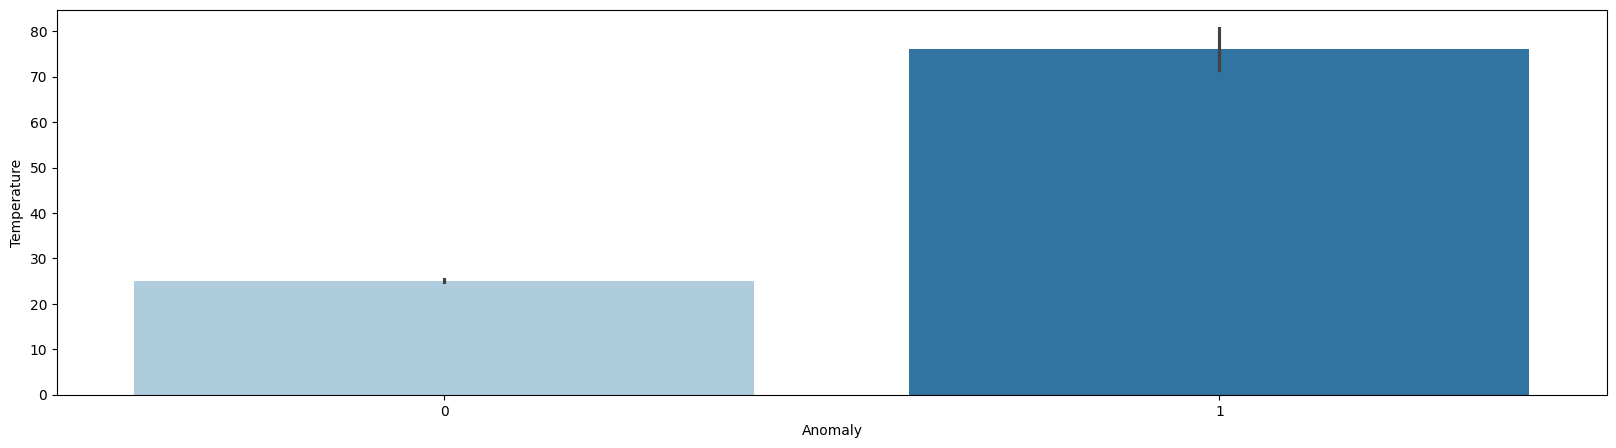

In [55]:
plt.figure(figsize=(20, 5))
# Create a bar plot with different colors for each bar
sns.barplot(data=data, x='Anomaly', y='Temperature', palette='Paired') 
# Show the plot
plt.show()

In [19]:
data = pd.get_dummies(data, columns=['Boiler Name'], dummy_na=False)
X = data.drop(['Anomaly', 'Timestamp'], axis=1) 
y = data['Anomaly']
X_train = data.drop("Timestamp", axis=1)

In [20]:
# Define features and target
X = data.drop('Timestamp', axis=1)
y = data['Timestamp']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
X = data.drop(['Timestamp'], axis=1)  
y = data['Anomaly']

In [22]:
print("Columns in X:", X.columns) 

Columns in X: Index(['Temperature', 'Anomaly', 'Year', 'Month', 'Day', 'Hour', 'Weekday',
       'Boiler Name_Boiler A', 'Boiler Name_Boiler B', 'Boiler Name_Boiler C',
       'Boiler Name_Boiler D'],
      dtype='object')


In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
np.random.seed(0)  # For reproducibility
y_true = np.random.randint(0, 2, 100)
y_pred = np.random.randint(0, 2, 100)
y_scores = np.random.rand(100)

In [42]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))

Accuracy: 0.49
Precision: 0.5555555555555556
Recall: 0.44642857142857145
F1 Score: 0.49504950495049505


In [43]:
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[24 20]
 [31 25]]


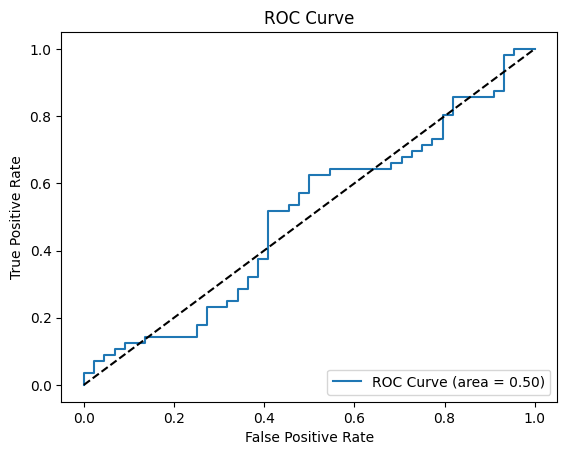

In [44]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc_score(y_true, y_scores))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Decision Tree

In [57]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Create a decision tree classifier model
clf = DecisionTreeClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [59]:
# Predict the test set results
y_pred = clf.predict(X_test)

In [60]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.86
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       111
           1       0.84      0.85      0.84        89

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



In [61]:
clf.score(X_train,y_train)

1.0

In [62]:
clf.score(X_test, y_test)

0.86

AUC: 1.000


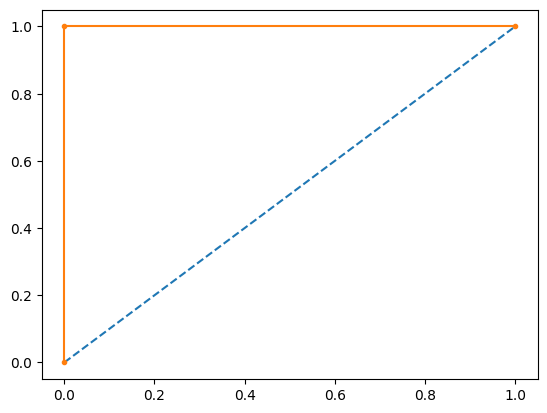

In [63]:
probs = clf.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

AUC: 0.859


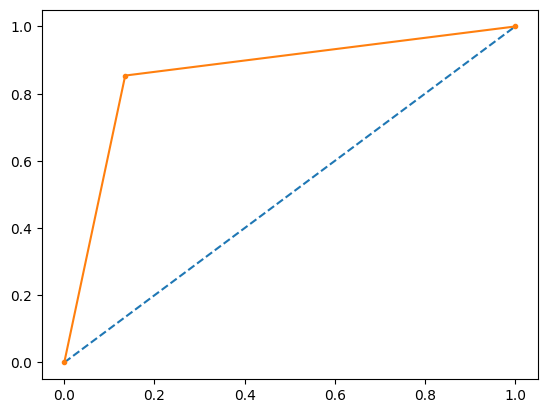

In [64]:
probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

Conclusion from above decision tree model is it performs moderate with training data(overfitted) and testing data (acceptable) with a accuracy of 86% and type 1 and type 2 errors are also low in this case. 

Logical Regression

In [67]:
# Initialize the Logistic Regression model
lmodel = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
lmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [68]:
# Predict on the test set
y_pred = lmodel.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.875
Confusion Matrix:
 [[99 12]
 [13 76]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89       111
           1       0.86      0.85      0.86        89

    accuracy                           0.88       200
   macro avg       0.87      0.87      0.87       200
weighted avg       0.87      0.88      0.87       200



In [70]:
lmodel.score(X_test,y_test)

0.875

In [71]:
lmodel.score(X_train,y_train)

0.85875

AUC: 0.925


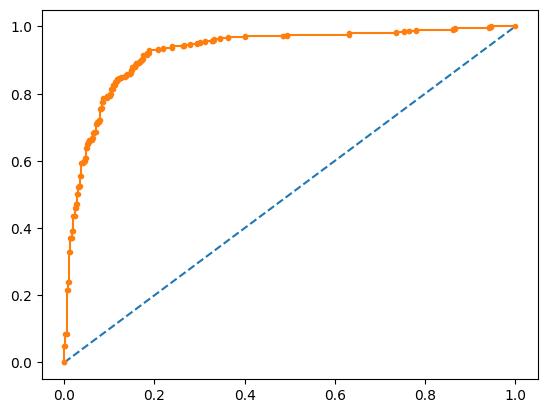

In [72]:
# AUC and ROC for the training data

# predict probabilities
probs = lmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

AUC: 0.928


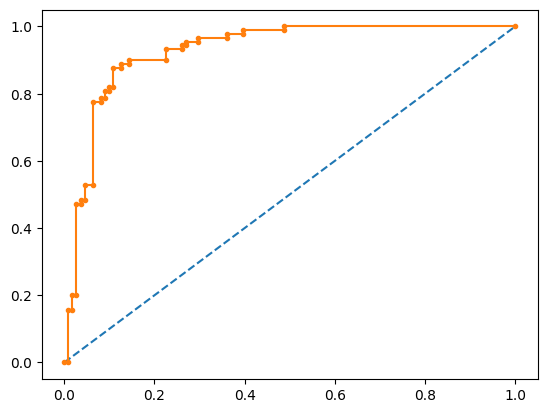

In [73]:
# AUC and ROC for the training data

# predict probabilities
probs = lmodel.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

Conclusion from above Logistic Regression model is that it performs moderate with training data and testing data with a accuracy of 88% and type 1 and type 2 errors are also moderate in this case.To improve accuracy we can do scaling and bagging techniques.

Random Forest Classifier

In [34]:
# Define features and target variable
X = data.drop('Anomaly', axis=1)
y = data['Anomaly']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
# Create a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

In [49]:
# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Detailed classification report
print(classification_report(y_test, y_pred))

# Compute the ROC AUC Score
roc_auc = roc_auc_score(y_test, y_scores)
print(f"ROC AUC Score: {roc_auc}")

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       135
           1       0.92      0.94      0.93       115

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250

ROC AUC Score: 0.9665700483091787


In [50]:
# Define the K-Fold cross-validation parameters
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print each fold's accuracy
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
print(f"CV Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores)}")

CV Scores: [0.90666667 0.89333333 0.92666667 0.94666667 0.95333333]
Mean CV Accuracy: 0.9253333333333333


In [51]:
rmodel = RandomForestClassifier(n_estimators=1000, random_state=42)
rmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [52]:
# Predicting the test set results
y_pred = rmodel.predict(X_test)

# Calculate and print the classification report and accuracy
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       135
           1       0.92      0.94      0.93       115

    accuracy                           0.93       250
   macro avg       0.93      0.93      0.93       250
weighted avg       0.93      0.93      0.93       250

Accuracy: 0.932


AUC: 1.000


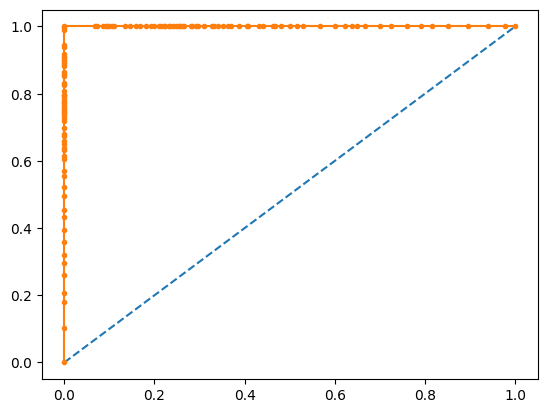

In [53]:
# AUC and ROC for the training data
# predict probabilities
probs = rmodel.predict_proba(X_train)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

AUC: 0.968


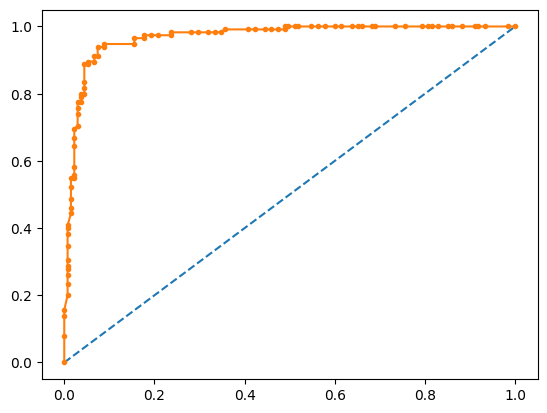

In [54]:
# AUC and ROC for the training data
# predict probabilities
probs = rmodel.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

Conclusion from above Random Forest Classifier is it performs well with training data(overfitted) and testing data (acceptable) with a accuracy of 93% and type 1 and type 2 errors are also low in this case. 

Here roc and auc score are good and great, better to distinguish the classes in the target variable but in real practical scenario is not possible. If need we can proceed with regularising the model and prevent this scenario, let we build this model with no regularisation techniques

Here we have dropped some unwanted features and build the model and got better accuracy but in case of inputs to be provided I have to select topmost features which gives the best accuracy so I will be proceeding with feature selection for my model to be tested for a new sample.

In [74]:
# Create an instance of each regression model
dtc = DecisionTreeClassifier(criterion='gini')
log_model = LogisticRegression()
Rand_model = RandomForestClassifier(n_estimators=500,oob_score=True)

# Train the models
dtc.fit(X_train,y_train)
log_model.fit(X_train,y_train)
Rand_model.fit(X_train,y_train)

# Make predictions on the test 
dtc_pred = dtc.predict(X_test)
log_pred = log_model.predict(X_test)
Rand_pre = Rand_model.predict(X_test)

# Evaluate the Models
dtc_acc = accuracy_score(y_test,dtc_pred)
log_acc = accuracy_score(y_test,log_pred)
Rand_acc = accuracy_score(y_test,Rand_pre)

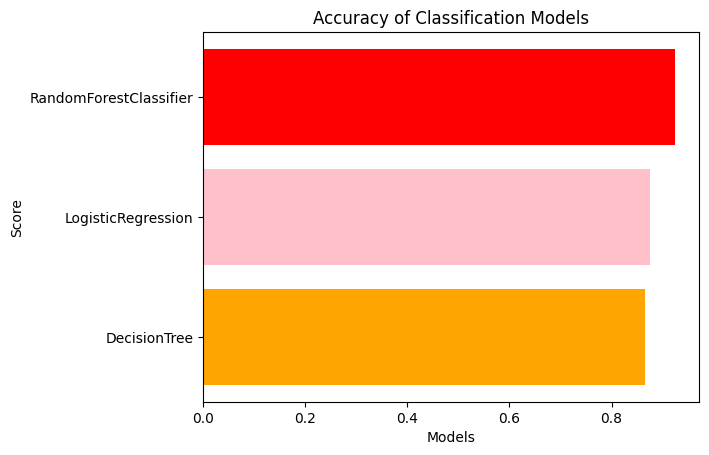

FINDING BEST FIT MODEL FOR EVALUATION BASED ON  ACCURACY

DecisionTree 0.865
LogisticRegression 0.875
RandomForestClassifier 0.925


In [75]:
models = ['DecisionTree', 'LogisticRegression', 'RandomForestClassifier']
score = [dtc_acc, log_acc, Rand_acc]

colors = ['orange', 'pink', 'red']
plt.barh(models, score, color=colors)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Accuracy of Classification Models')
#ax.set_facecolor('black')
plt.show()

print("FINDING BEST FIT MODEL FOR EVALUATION BASED ON  ACCURACY\n")
max_score = max(score)  # Initialize max_score with the maximum value in the score list
max_model = ""

for model, score_value in zip(models, score):
    print(model, score_value)
    if score_value == max_score:
        max_model = model

In [76]:
print(f"\nModel: {max_model} contain Maximum accuracy: {max_score} ")


Model: RandomForestClassifier contain Maximum accuracy: 0.925 


In [79]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
scaler=StandardScaler()
ohe=OneHotEncoder()

In [80]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelBinarizer

In [81]:
data

,Timestamp,Temperature,Anomaly,Year,Month,Day,Hour,Weekday,Boiler Name_Boiler A,Boiler Name_Boiler B,Boiler Name_Boiler C,Boiler Name_Boiler D
0,0.806955,20.180428,0,2023,1,23,0,0,True,False,False,False
184,-1.404245,17.767659,0,2023,1,3,10,1,True,False,False,False
454,-1.133629,26.145468,0,2023,1,5,20,3,True,False,False,False
664,-1.629151,32.510135,0,2023,1,1,10,6,True,False,False,False
867,-0.661247,27.261244,0,2023,1,10,0,1,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
755,0.167877,23.765050,0,2023,1,17,8,1,False,False,False,True
753,0.473410,23.061176,0,2023,1,20,1,4,False,False,False,True
334,0.327591,24.467502,0,2023,1,18,18,2,False,False,False,True
380,1.583305,34.185353,0,2023,1,29,22,6,False,False,False,True


In [90]:
Y = data['Temperature']
X= data[['Anomaly','Timestamp',	'Year',	'Month', 'Day',	'Hour',	'Weekday',	'Boiler Name_Boiler A',	'Boiler Name_Boiler B',	'Boiler Name_Boiler C',	'Boiler Name_Boiler D']]

# encoding categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')
# independent features after encoding
X = np.array(X[['Anomaly','Timestamp',	'Year',	'Month', 'Day',	'Hour',	'Weekday',	'Boiler Name_Boiler A',	'Boiler Name_Boiler B',	'Boiler Name_Boiler C',	'Boiler Name_Boiler D']])
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)
# decision tree classifier
rfcls = RandomForestClassifier()
rfcls.fit(X_train, y_train)
y_pred = rfcls.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

Accuracy: 0.53
Confusion Matrix:
[[78 69]
 [72 81]]


In [88]:
import pickle as pk

In [91]:
with open('Model.pkl','wb') as file:
    pk.dump(rfcls,file)
with open('Scaler.pkl','wb') as file:
    pk.dump(scaler,file)
with open('ct.pkl','wb') as file:
    pk.dump(ohe,file)

<Axes: xlabel='Temperature', ylabel='Count'>

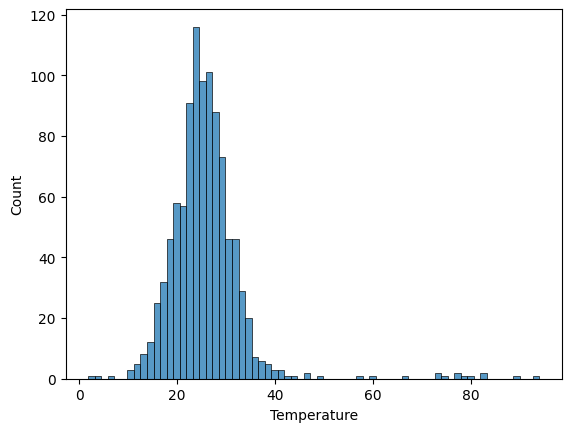

In [96]:
sns.histplot(data['Temperature'])